In [112]:
#Coefficient of multiple correlation
# The phenotypic characteristics of each stomata complex is extracted by the Mask RCNN and CellProifler pipeline
# !pip install pycytominer
import pandas as pd
import pycytominer
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
morph = pd.read_csv("./Nia_normalized_avgSCO.csv")

morph.head()

,Unnamed: 0,Metadata_week.x,Metadata_genotype.x,Group,Subgroup,GCO_AreaShape_Area,GCO_AreaShape_BoundingBoxArea,GCO_AreaShape_Compactness,GCO_AreaShape_ConvexArea,GCO_AreaShape_Eccentricity,...,avg_sco_Solidity,avg_sco_MaxFeretDiameter,avg_sco_MedianRadius,avg_sco_MajorAxisLength,avg_sco_Extent,avg_sco_Area,avg_sco_MaximumRadius,avg_sco_FormFactor,avg_sco_Compactness,avg_sco_EquivalentDiameter
0,0,1,A619,NSS,NSS-M14:Oh43,-1.079019,-0.272454,0.673359,-1.113983,0.825861,...,0.311238,-0.517258,-0.637130,-0.557692,0.543585,-0.879906,-0.975729,-0.313848,0.207784,-0.881745
1,1,1,A619,NSS,NSS-M14:Oh43,-0.851779,0.216723,0.367747,-0.717894,0.390714,...,-2.465565,-0.429283,-1.628891,-0.524388,-1.829892,-1.063557,-0.870426,-1.533431,1.690007,-1.094658
2,2,1,A619,NSS,NSS-M14:Oh43,-0.315073,0.251874,0.133666,-0.163371,0.301012,...,-0.121707,-0.058817,-0.637130,-0.110047,-0.543853,-0.824811,-0.870426,-1.012754,1.002187,-0.819087
3,3,1,A619,NSS,NSS-M14:Oh43,-1.913231,-1.611099,1.740203,-1.879306,1.426928,...,-0.745735,0.003574,-0.637130,-0.272004,-1.369564,-0.490900,-0.121496,-0.951300,0.926840,-0.450329
4,4,1,A619,NSS,NSS-M14:Oh43,0.845049,1.285296,0.479610,0.861089,0.519303,...,-1.192595,1.030877,-1.328367,0.795901,-1.831582,-0.399074,-0.466572,-2.103622,2.561495,-0.352000


     Unnamed: 0 Metadata_week.x Metadata_genotype.x Group      Subgroup  \
0             0               1                A619   NSS  NSS-M14:Oh43   
1             1               1                A619   NSS  NSS-M14:Oh43   
2             2               1                A619   NSS  NSS-M14:Oh43   
3             3               1                A619   NSS  NSS-M14:Oh43   
4             4               1                A619   NSS  NSS-M14:Oh43   
..          ...             ...                 ...   ...           ...   
553         553               5                OH43   NSS  NSS-M14:Oh43   
554         554               5                OH43   NSS  NSS-M14:Oh43   
555         555               5                OH43   NSS  NSS-M14:Oh43   
556         556               5                OH43   NSS  NSS-M14:Oh43   
557         557               5                OH43   NSS  NSS-M14:Oh43   

     GCO_AreaShape_Area  GCO_AreaShape_BoundingBoxArea  \
0             -1.079019                  

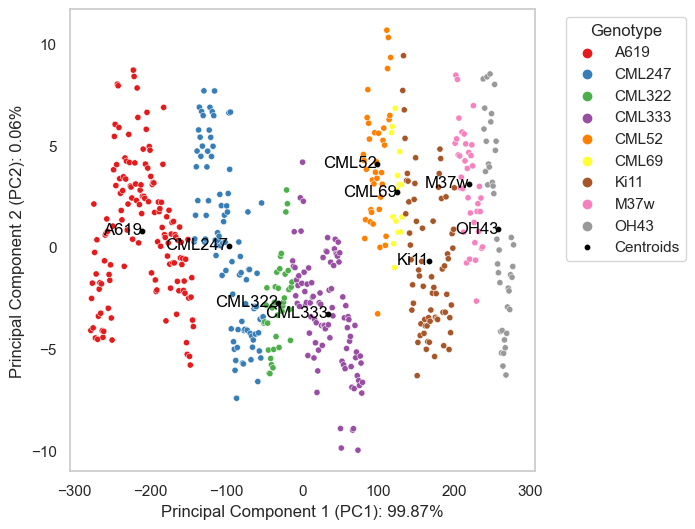

[9.98726711e-01 5.97717431e-04 2.67200113e-04 1.63515424e-04
 9.70218001e-05 7.80523676e-05 1.95530329e-05 1.59547556e-05
 7.05652993e-06 6.22825600e-06 4.34735755e-06 3.57154784e-06
 2.86228247e-06 2.12020359e-06 1.59520839e-06 1.35730778e-06
 1.00622229e-06 8.86536010e-07 7.90851362e-07 4.76941501e-07
 4.41856893e-07 3.22036330e-07 2.89269553e-07 2.48391078e-07
 1.57229303e-07 1.31048732e-07 1.16492485e-07 7.44757721e-08
 7.16494463e-08 3.95448832e-08 3.35361881e-08 2.09275084e-08
 1.84230426e-08 6.71327516e-09 3.28181058e-09]


In [124]:
# Redo the PCA base on average parameters of SCO1 and SCO2, lable by genotype
df = morph.copy()
print(df)
# Select numeric columns for normalization
df = df.dropna()
numeric_columns = df.select_dtypes(include='number')
pca = PCA()
pca_result = pca.fit_transform(numeric_columns)

# Create a DataFrame with PCA results
pca_columns = [f'PC{i+1}' for i in range(pca_result.shape[1])]
pca_df = pd.DataFrame(data=pca_result, columns=pca_columns)

# Concatenate the PCA DataFrame with non-numeric columns
final_df = pd.concat([df.drop(columns=numeric_columns.columns), pca_df], axis=1)

# Calculate centroids of each genotype
centroids = final_df.groupby('Metadata_genotype.x')[['PC1', 'PC2']].mean()

# Plotting PCA results with color labels based on 'Metadata_genotype.x'
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.grid(False)

sns.scatterplot(x='PC1', y='PC2', hue='Metadata_genotype.x', data=final_df, palette='Set1', s=20)

plt.scatter(centroids['PC1'], centroids['PC2'], color='black', marker='o', s=10, label='Centroids')

# Annotate centroids
for idx, centroid in centroids.iterrows():
    # Adjust the position of labels slightly to avoid overlap with circles
    plt.text(centroid['PC1'] + 0.05, centroid['PC2'] + 0.05, idx, fontsize=12, color='black', ha='right', va='center')
    
plt.xlabel(f'Principal Component 1 (PC1): {pca.explained_variance_ratio_[0]*100:.2f}%')
plt.ylabel(f'Principal Component 2 (PC2): {pca.explained_variance_ratio_[1]*100:.2f}%')
plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
print(pca.explained_variance_ratio_)

/Users/houlinyu/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


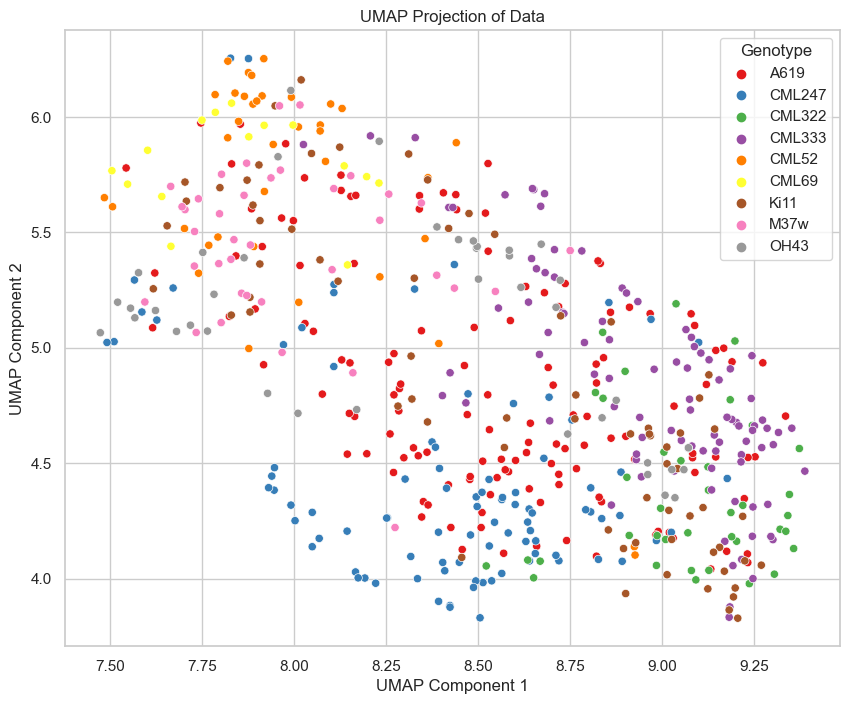

In [48]:
### UMAP
import umap
df = morph.copy()
features = df.filter(regex='^(GCO|avg_)')
genotype = df['Metadata_genotype.x']

# Initialize UMAP with desired parameters
umap_model = umap.UMAP(n_neighbors=30, min_dist=0.3, n_components=50, random_state=42)

# Fit UMAP to your data and transform it to the lower-dimensional space
umap_result = umap_model.fit_transform(features)

# Plot the UMAP projection, color-coded by genotype
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=genotype, palette='Set1', legend='full')
plt.title('UMAP Projection of Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Genotype')
plt.show()





In [75]:
### Train Random forest classifier

# In general, Random Forest is not sensitive to the scale of the features
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
df = morph.copy()
df = df.dropna()


# Assuming X is your feature matrix, y is your target variable (genotype)
#X = df_GC0_AVG_SCO.filter(regex='^(GCO|avg_)').filter(like="Ratio_G_S_area")
X = df.filter(regex='^(avg)')
y = df.filter(['Metadata_genotype.x'])

# Initialize LabelEncoder
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)

# Initialize the RandomForestClassifier, random_state: 
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=None)


# Fit the classifier to your data
rf_classifier.fit(X, y_encoded )

# Get feature importances from the trained model
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]

# Get the names of the features in the original order
feature_names = X.columns[sorted_indices]


/Users/houlinyu/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [76]:
sorted_importances 
Nia_feature_order = feature_names
Nia_feature_order

df = pd.DataFrame(Nia_feature_order, columns=['Column_Names'])
df.to_csv("Nia_feature_order.csv")

print(df)

                  Column_Names
0               avg_sco_Extent
1         avg_sco_Eccentricity
2           avg_sco_FormFactor
3             avg_sco_Solidity
4          avg_sco_Compactness
5     avg_sco_MaxFeretDiameter
6      avg_sco_MajorAxisLength
7      avg_sco_MinorAxisLength
8      avg_sco_BoundingBoxArea
9           avg_sco_MeanRadius
10    avg_sco_MinFeretDiameter
11                avg_sco_Area
12           avg_sco_Perimeter
13  avg_sco_EquivalentDiameter
14       avg_sco_MaximumRadius
15          avg_sco_ConvexArea
16        avg_sco_MedianRadius


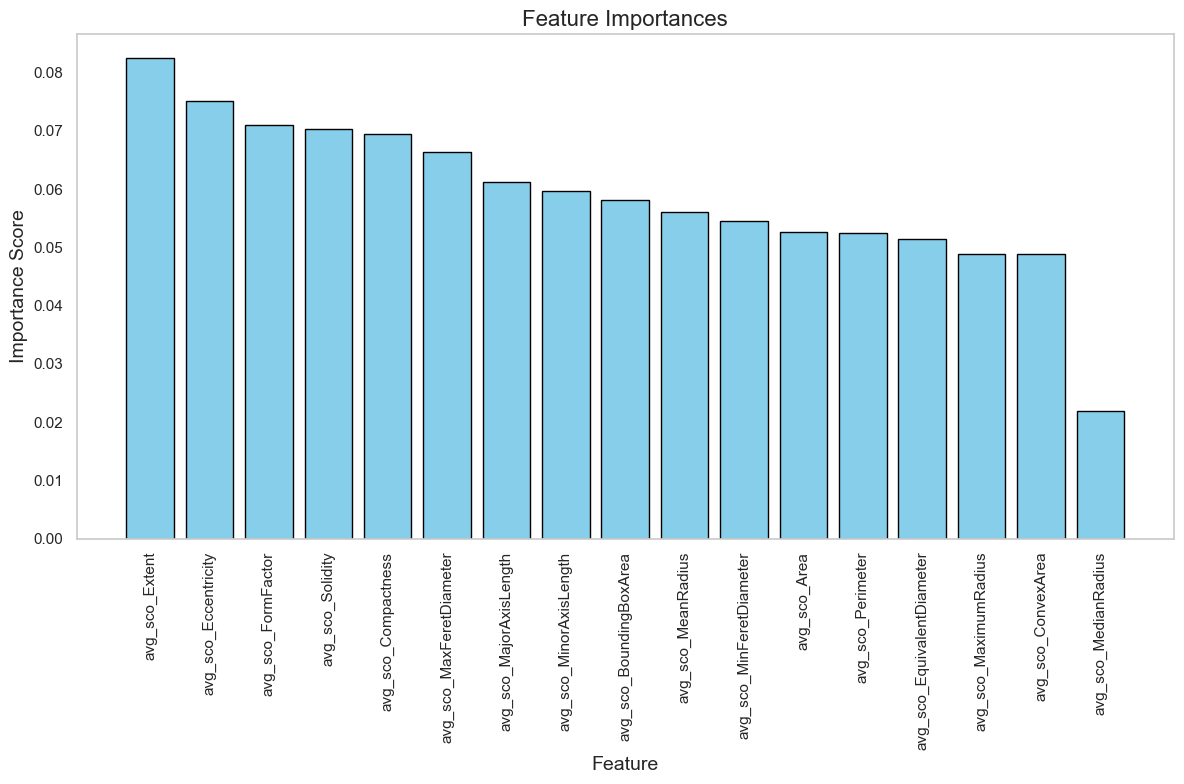

In [77]:
# Create a bar plot of feature importances

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

# Turn off grid lines
#plt.grid(False)

# Define colors for SCO and GCO features
colors = ['skyblue' if 'avg' in name else 'gray' for name in feature_names]

plt.bar(range(X.shape[1]), sorted_importances, color=colors, edgecolor='black')
plt.grid(False)
plt.xticks(range(X.shape[1]), feature_names, rotation=90)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Importance Score', fontsize=14)
plt.title('Feature Importances', fontsize=16)
plt.tight_layout()
plt.show()



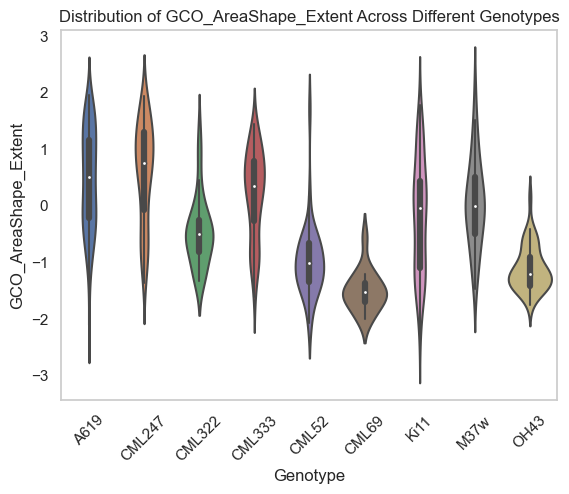

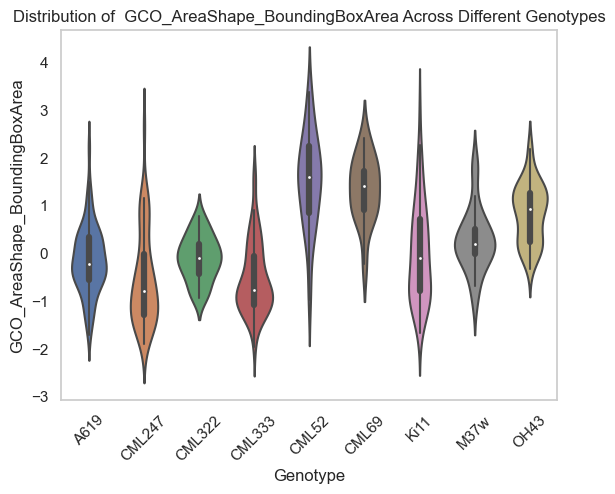

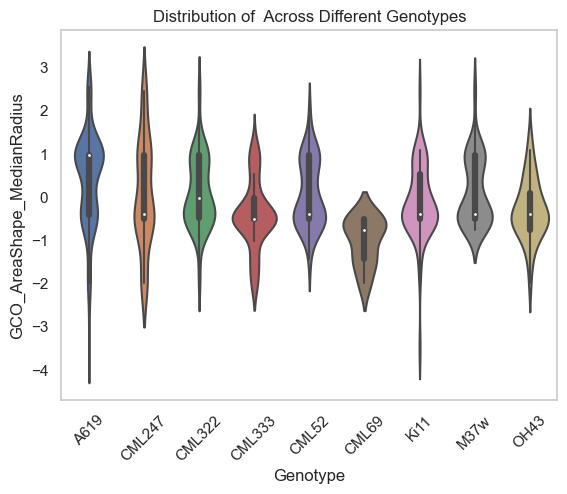

In [78]:
# Visulize the first and the last features

sns.violinplot(x='Metadata_genotype.x', y='GCO_AreaShape_Extent', data=morph)
plt.grid(False)
plt.title('Distribution of GCO_AreaShape_Extent Across Different Genotypes')
plt.xlabel('Genotype')
plt.ylabel('GCO_AreaShape_Extent')
plt.xticks(rotation=45)
plt.show()


sns.violinplot(x='Metadata_genotype.x', y='GCO_AreaShape_BoundingBoxArea', data=morph)
plt.grid(False)
plt.title('Distribution of  GCO_AreaShape_BoundingBoxArea Across Different Genotypes')
plt.xlabel('Genotype')
plt.ylabel('GCO_AreaShape_BoundingBoxArea')
plt.xticks(rotation=45)
plt.show()

sns.violinplot(x='Metadata_genotype.x', y='GCO_AreaShape_MedianRadius', data=morph)
plt.grid(False)
plt.title('Distribution of  Across Different Genotypes')
plt.xlabel('Genotype')
plt.ylabel("GCO_AreaShape_MedianRadius")
plt.xticks(rotation=45)
plt.show()

In [79]:
# Evaluate Model Performance on all feture

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

df =morph.copy()

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier with a fixed random_state
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)

# Fit the classifier to your data
rf_classifier.fit(X_train, y_train)

# Predictions on the testing set
y_pred = rf_classifier.predict(X_test)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Evaluating the classifier, Accuracy= Total number of predictions/Number of correct predictions
accuracy = rf_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)


/Users/houlinyu/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Precision: 0.461121096165739
Recall: 0.4107142857142857
F1 Score: 0.39436245145831617
Accuracy: 0.4107142857142857


/Users/houlinyu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      Metric     Value       Source
0  Precision  0.461121          SCO
1     Recall  0.410714          SCO
2   F1 Score  0.394362          SCO
3   Accuracy  0.410714          SCO
0  Precision  0.586999          GCO
1     Recall  0.571429          GCO
2   F1 Score  0.565373          GCO
3   Accuracy  0.565373          GCO
0  Precision  0.619869  Combination
1     Recall  0.580357  Combination
2   F1 Score  0.583664  Combination
3   Accuracy  0.580357  Combination


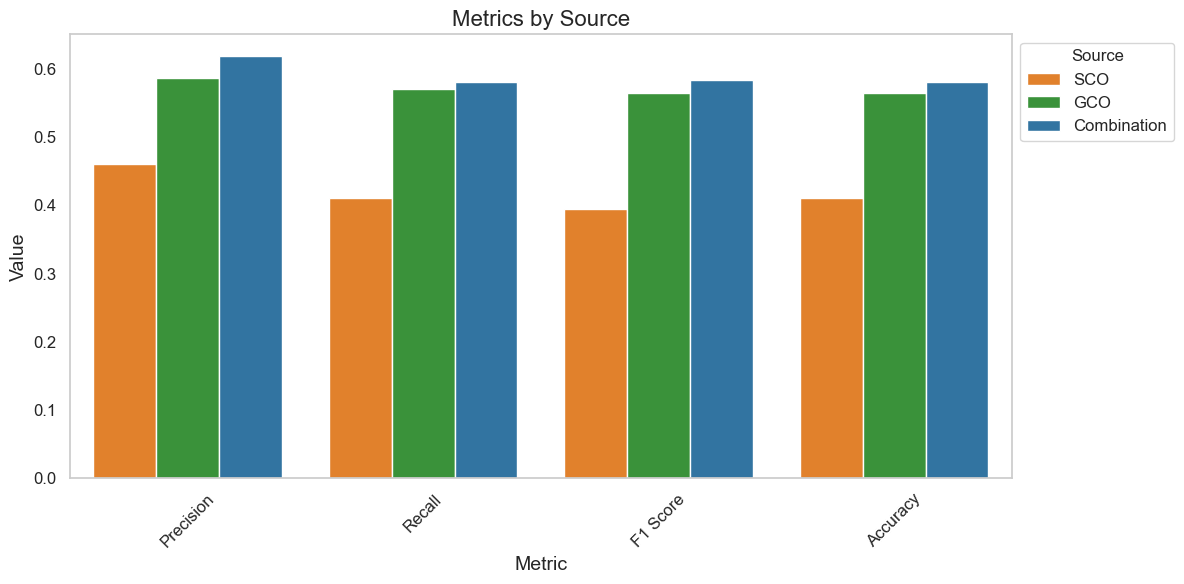

In [108]:
# Define the precision, recall, F1 score, and accuracy values
precision = 0.6198689703153989
recall = 0.5803571428571429
f1_score = 0.5836637286493545
accuracy = 0.5803571428571429

# Create a DataFrame
metrics_df1 = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
    'Value': [precision, recall, f1_score, accuracy],
    'Source': ['Combination'] * 4
})



precision =  0.5869994588744588
recall =  0.5714285714285714
f1_score = 0.5653725718488495
accuracy = 0.5653725718488495

# Create a DataFrame
metrics_df2 = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
    'Value': [precision, recall, f1_score, accuracy],
    'Source': ['GCO'] * 4
})





precision =  0.461121096165739
recall =  0.4107142857142857
f1_score = 0.39436245145831617
accuracy = 0.4107142857142857

# Create a DataFrame
metrics_df3 = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
    'Value': [precision, recall, f1_score, accuracy],
    'Source': ['SCO'] * 4
})



# combine three dfs:

combined_matrix = pd.concat([metrics_df3, metrics_df2, metrics_df1], axis=0)

print(combined_matrix)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Value', hue='Source', data=combined_matrix, palette=palette)
plt.grid(False)

# Adjusting labels and title
plt.title('Metrics by Source', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Source', fontsize=12, bbox_to_anchor=(1, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

In [111]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

# Assuming y_true are the true labels and y_pred are the predicted labels by your Random Forest classifier
y_true = y_test  # True labels from the test set
y_pred = rf_classifier.predict(X_test)  # Predicted labels by your Random Forest classifier

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Compute class-wise precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)

# Print results
print("Confusion Matrix:")
print(cm)

print("\nClass-wise Metrics:")
for i in range(len(precision)):
    print(f"Genotype {i}: Precision={precision[i]}, Recall={recall[i]}, F1 Score={f1[i]}")

print("\nOverall Accuracy:", accuracy)

# Get the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("Original Label -> Encoded Label:")
for original_label, encoded_label in label_mapping.items():
    print(f"{original_label} -> {encoded_label}")


Confusion Matrix:
[[19  3  2  4  2  0  1  3  0]
 [ 7  9  0  0  0  0  2  0  0]
 [ 1  2  5  2  0  0  1  0  0]
 [ 4  1  0  4  1  0  0  0  0]
 [ 2  0  0  0  4  0  2  1  0]
 [ 1  0  0  0  1  0  1  0  0]
 [ 2  3  0  3  0  0  2  0  0]
 [ 1  1  0  0  1  0  1  2  0]
 [ 5  2  1  1  0  0  1  0  1]]

Class-wise Metrics:
Genotype 0: Precision=0.4523809523809524, Recall=0.5588235294117647, F1 Score=0.5
Genotype 1: Precision=0.42857142857142855, Recall=0.5, F1 Score=0.4615384615384615
Genotype 2: Precision=0.625, Recall=0.45454545454545453, F1 Score=0.5263157894736842
Genotype 3: Precision=0.2857142857142857, Recall=0.4, F1 Score=0.3333333333333333
Genotype 4: Precision=0.4444444444444444, Recall=0.4444444444444444, F1 Score=0.4444444444444444
Genotype 5: Precision=0.0, Recall=0.0, F1 Score=0.0
Genotype 6: Precision=0.18181818181818182, Recall=0.2, F1 Score=0.1904761904761905
Genotype 7: Precision=0.3333333333333333, Recall=0.3333333333333333, F1 Score=0.3333333333333333
Genotype 8: Precision=1.0, Re

/Users/houlinyu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


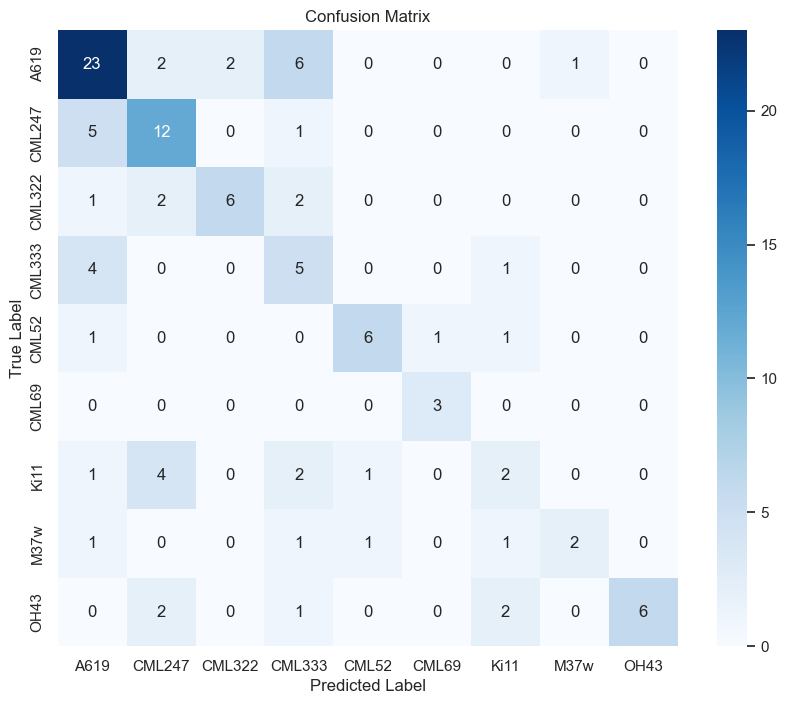

In [59]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
genotypes = df['Metadata_genotype.x'].unique()

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=genotypes, yticklabels=genotypes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

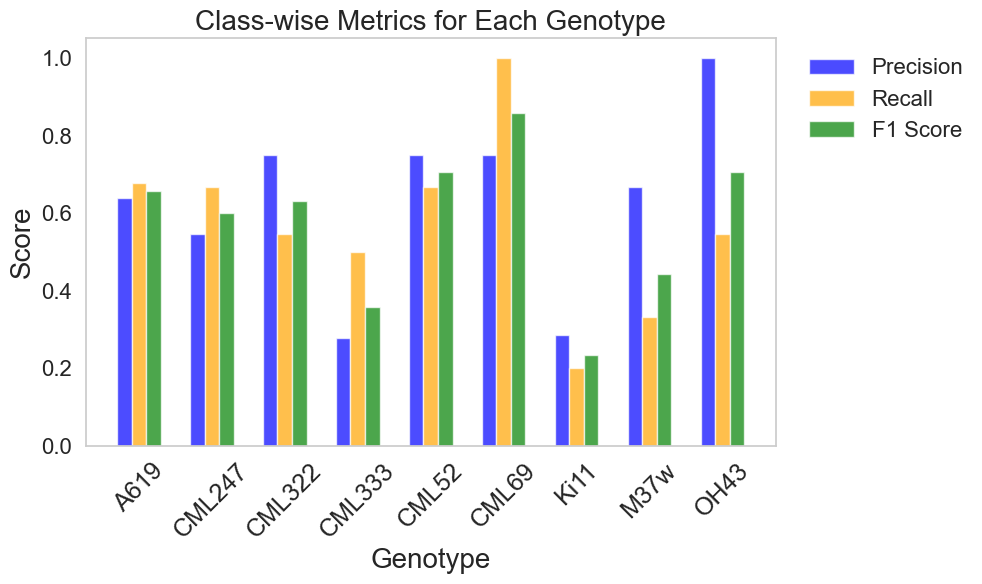

In [60]:

y_true = y_test  # True labels from the test set
y_pred = rf_classifier.predict(X_test)  # Predicted labels by your Random Forest classifier

# Compute class-wise precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Define the number of genotypes and metrics
num_genotypes = len(genotypes)
num_metrics = 4

# Set the positions for the bars
bar_width = 0.2
index = np.arange(num_genotypes)

# Plotting
plt.figure(figsize=(10, 6), facecolor='none')
plt.grid(False)

plt.bar(index - bar_width, precision, label='Precision', color='blue', width=bar_width, alpha=0.7)
plt.bar(index, recall, label='Recall', color='orange', width=bar_width, alpha=0.7)
plt.bar(index + bar_width, f1_score, label='F1 Score', color='green', width=bar_width, alpha=0.7)

plt.title('Class-wise Metrics for Each Genotype', fontsize=20)
plt.xlabel('Genotype', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.xticks(index, genotypes, rotation=45, fontsize=18)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.legend(fontsize=16, loc='upper left',  bbox_to_anchor=(1.02, 1), frameon=False)

plt.tight_layout()
plt.show()


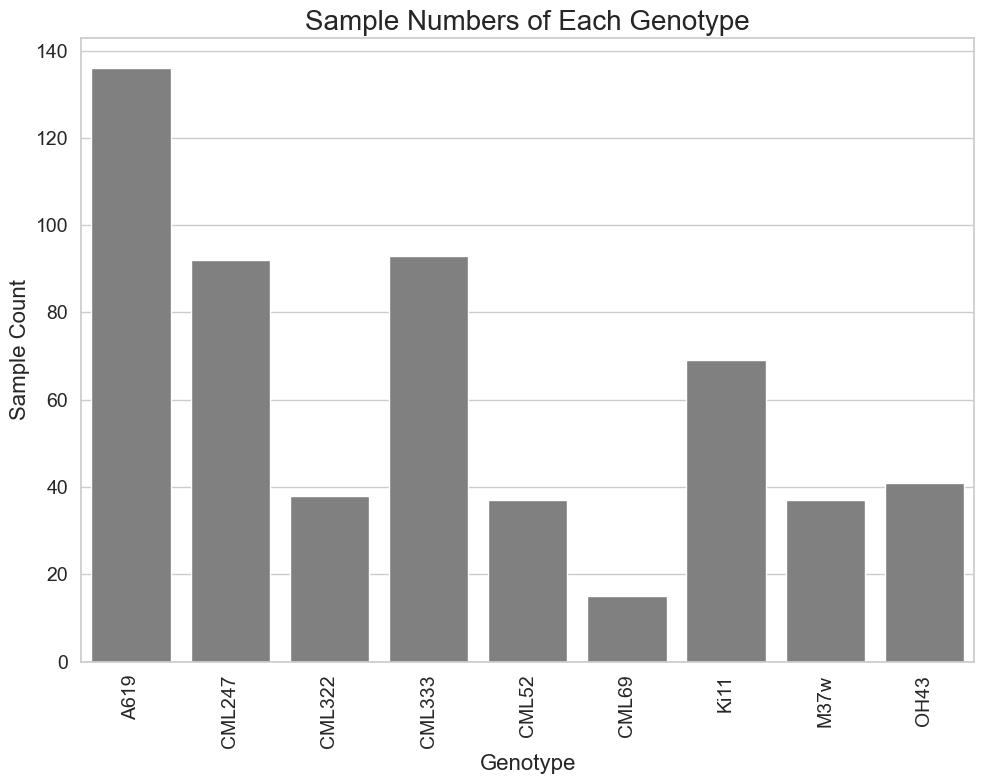

In [61]:
# Create a countplot with gray color for all genotypes
plt.figure(figsize=(10, 8))
ax = sns.countplot(x='Metadata_genotype.x', data=morph, color='gray')

# Set the title and labels
plt.title('Sample Numbers of Each Genotype', fontsize=20)
plt.xlabel('Genotype', fontsize=16)
plt.ylabel('Sample Count', fontsize=16)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

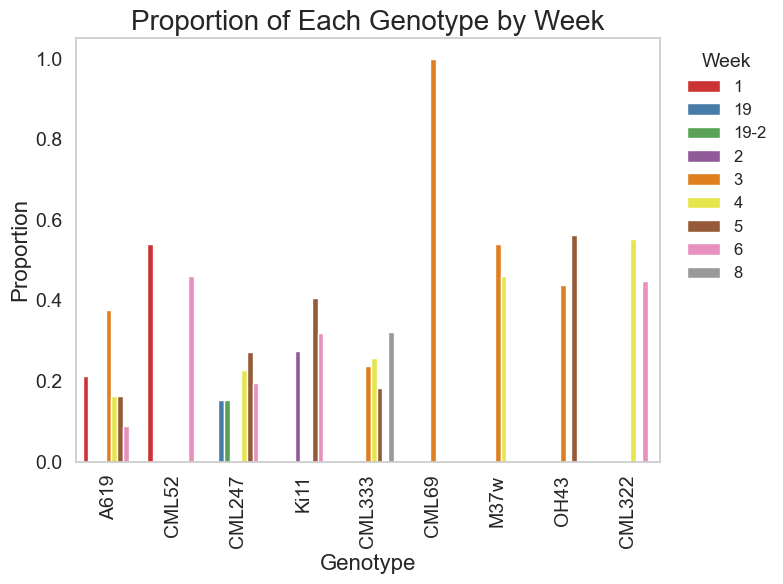

In [37]:
# Compute sample numbers of each genotype grouped by Metadata_week.x and Metadata_genotype.x
sample_counts = morph.groupby(['Metadata_week.x', 'Metadata_genotype.x']).size().reset_index(name='Sample Count')

# Compute the proportion of each genotype within each week
sample_counts['Proportion'] = sample_counts.groupby('Metadata_genotype.x')['Sample Count'].transform(lambda x: x / x.sum())

# Create a countplot
plt.figure(figsize=(8, 6))
sns.barplot(y='Proportion', x='Metadata_genotype.x', hue='Metadata_week.x', data=sample_counts, palette='Set1')

plt.title('Proportion of Each Genotype by Week', fontsize=20)
plt.xlabel('Genotype', fontsize=16)
plt.ylabel('Proportion', fontsize=16)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.grid(False)
plt.legend(title='Week', fontsize=12, title_fontsize=14, loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False)

plt.tight_layout()
plt.show()

    Metadata_genotype.x  index2
0                CML247     158
1                  Ki11     451
2                  A619      55
3                CML322     247
4                  A619      70
..                  ...     ...
107                A619      11
108               CML52     374
109                A619      22
110               CML52     381
111               CML52     373

[112 rows x 2 columns]
   Metadata_genotype.x_x  index2  index pred_genotype.x  Unnamed: 0  \
0                   Ki11     451      1          CML247         451   
1                   A619      55      2          CML333          55   
2                 CML322     247      3          CML333         247   
3                  CML52     382      6           CML69         382   
4                   M37w     516      8            Ki11         516   
5                 CML247     218     10          CML333         218   
6                 CML247     199     13            A619         199   
7                   A619

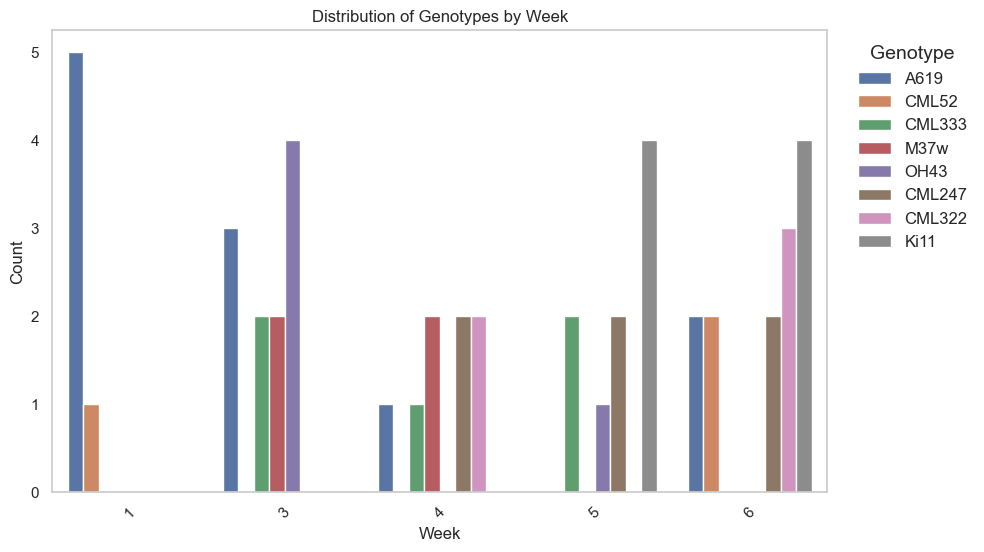

In [38]:
### Detect if the wrong lable for certain genotype is from the same image or not

df = pd.DataFrame(y_pred, columns=['pred_genotype.x'])
df['index'] = df.index

y_true['index2'] = y_true.index
y_true.reset_index(drop=True, inplace=True)

print(y_true)

y_true['index'] = y_true.index
merged_df = pd.merge(y_true, df, on='index')

# Filter rows where 'Metadata_genotype.x' is not equal to 'pred_genotype.x'
filtered_df = merged_df[merged_df['Metadata_genotype.x'] != merged_df['pred_genotype.x']]

# Merge the base DataFrame with the week DataFrame based on the index
merged_df2 = pd.merge(filtered_df, morph, left_on = 'index2', right_on='Unnamed: 0')

merged_df2 = merged_df2.iloc[:, :7]


print(merged_df2)
# Count occurrences of each genotype by week
genotype_counts = merged_df2.groupby(['Metadata_week.x', 'Metadata_genotype.x_x']).size().reset_index(name='Count')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=genotype_counts, x='Metadata_week.x', y='Count', hue='Metadata_genotype.x_x')
plt.grid(False)
plt.xlabel('Week')
plt.ylabel('Count')
plt.title('Distribution of Genotypes by Week')
plt.legend(title='Genotype', fontsize=12, title_fontsize=14, loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False)
plt.xticks(rotation=45)
plt.show()

      Metric  All_feature       SCO       GCO
0  Precision     0.697872  0.575083  0.663166
1     Recall     0.688341  0.567265  0.647982
2   F1 Score     0.685820  0.564795  0.641036
3   Accuracy     0.688341  0.567265  0.647982


<Figure size 1000x600 with 0 Axes>

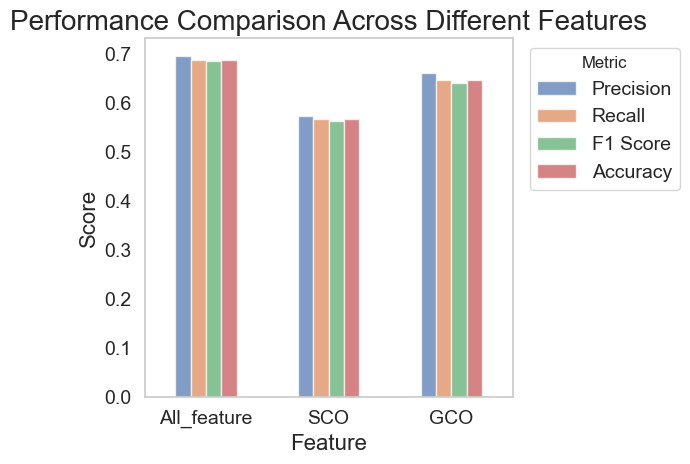

In [204]:
### use the same pipeline, but use individual GCO and SCO features and comparing the performance

# Define the data
data = {
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
    'All_feature': [0.6978723168837083, 0.6883408071748879, 0.6858196011071382, 0.6883408071748879],
    'SCO': [0.5750834622950078, 0.5672645739910314, 0.5647948042819123, 0.5672645739910314],
    'GCO': [0.6631655033594059, 0.647982062780269, 0.6410359584266648, 0.647982062780269]
}

# Create DataFrame
df = pd.DataFrame(data)
print(df)

# Plotting
plt.figure(figsize=(10, 6))

df_transposed = df.set_index('Metric').transpose()
df_transposed.plot(kind='bar', alpha=0.7)
plt.title('Performance Comparison Across Different Features', fontsize=20)
plt.xlabel('Feature', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Metric', fontsize=14, loc='upper left', bbox_to_anchor=(1.02, 1))
plt.grid(False)

plt.tight_layout()
plt.show()

/var/folders/gt/w451x6dd2xs29hm6r8jx9bph0000gn/T/ipykernel_41958/222282026.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(genotypes).mean()
/var/folders/gt/w451x6dd2xs29hm6r8jx9bph0000gn/T/ipykernel_41958/222282026.py:23: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = hierarchy.linkage(distance_matrix, method='complete')


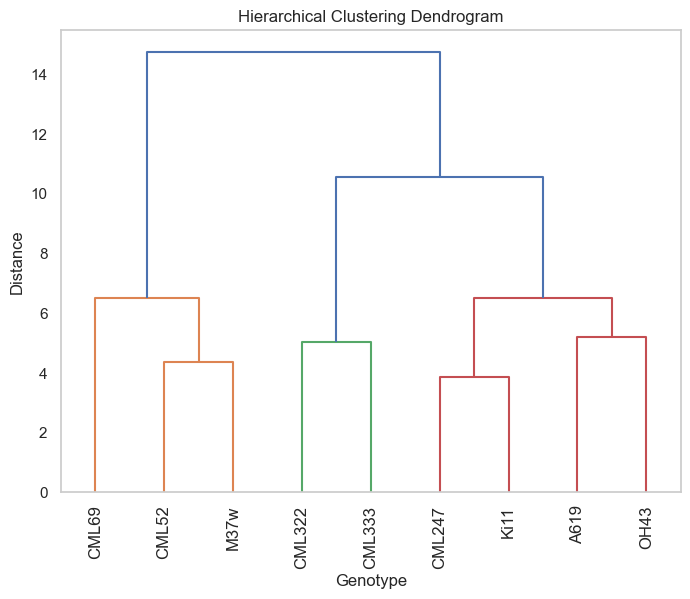

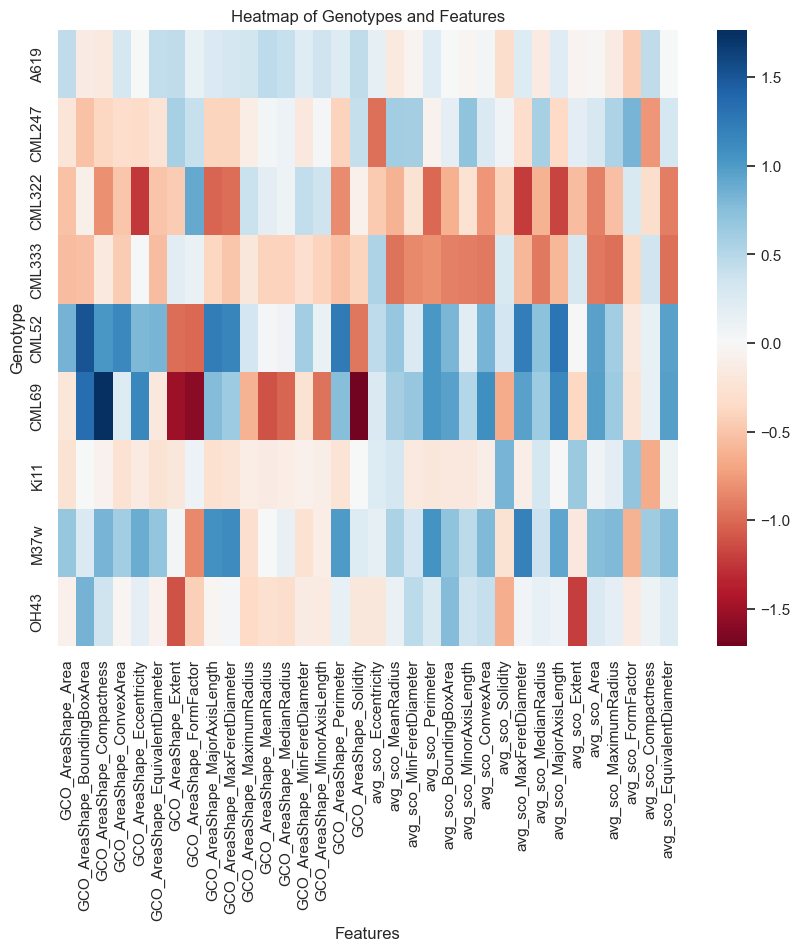

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.cluster import hierarchy
# Load the data
data = morph.copy()

genotypes = data['Metadata_genotype.x']

# Aggregate data for each genotype by calculating the mean
aggregated_data = data.groupby(genotypes).mean()

# Select relevant features for building the phylogenetic tree
selected_features = aggregated_data.filter(regex='^(GCO|avg_)')
# bset the data frame to include only the selected features
data = selected_features

# Calculate the distance matrix using Euclidean distance
distance_matrix = distance.squareform(distance.pdist(data, metric='euclidean'))

# Perform hierarchical clustering using complete linkage
clustering = hierarchy.linkage(distance_matrix, method='complete')

# Plot the dendrogram
plt.figure(figsize=(8, 6))
plt.grid(False)
dendrogram = hierarchy.dendrogram(clustering, labels=aggregated_data.index, orientation='top')

# Add title and labels
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Genotype')
plt.ylabel('Distance')

plt.xticks(rotation=90)
plt.show()

# Create a heatmap with a diverging colormap
plt.figure(figsize=(10, 8))
sns.heatmap(data, cmap='RdBu', center=0, cbar=True)  # Use 'RdBu' colormap for red to blue transition
plt.title('Heatmap of Genotypes and Features')
plt.xlabel('Features')
plt.ylabel('Genotype')
plt.show()